In [315]:
import fluxy as fl
from influxdb_client.client.influxdb_client_async import InfluxDBClientAsync
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta
import pandas as pd 
import seaborn as sns 
import matplotlib.dates as mdates
import matplotlib.pylab as plt 

load_dotenv()

API_TOKEN = os.getenv("ENERGY_REPORT_API_TOKEN")
# electricity generated
# heat generated
# grid import -> 0 hopefully
# battery level
# cooling demand
# fancoil settings
# water consumption

In [308]:
start = datetime.now(timezone.utc) - timedelta(days=7)
stop = datetime.now(timezone.utc)
window_size = timedelta(minutes=10)

In [309]:
from pandas import DataFrame


async def submit_query(fl) -> DataFrame:
  async with InfluxDBClientAsync("https://influxdb.prod.power-hub.foundationzero.org", API_TOKEN, "power_hub") as client:
    print(fl.to_flux())
    return await client.query_api().query_data_frame(fl.to_flux())
  
from typing import Any

async def get_data(
    sensors_to_query: list[Any],
    query_range: tuple[datetime, datetime],
    resolution: timedelta,
    windowoperation: fl.WindowOperation,
) -> pd.DataFrame:

    query = fl.pipe(
        fl.from_bucket("power_hub"),
        fl.range(*query_range),
        fl.filter(fl.any(fl.conform, sensors_to_query)),
        fl.aggregate_window(resolution, windowoperation, False),
        fl.keep(["_time", "_value", "_field"]),
        fl.pivot(["_time"], ["_field"], "_value"),
    )

    print(query) 
    
    df = await submit_query(query)

    return df.drop(columns = ["result","table"]).set_index("_time",drop = True).sort_index()

In [442]:
sns.set_style("whitegrid")

def plot_hourly_avg(data):
    hourly_electric = data.set_index(data.index.hour)
    hourly_electric = hourly_electric.stack().to_frame(name = 'kWh').reset_index(names = ['hour', 'group'])

    fig, ax = plt.subplots()
    sns.lineplot(data = hourly_electric, x = 'hour', y= 'kWh', hue = 'group', palette = 'Paired', dashes = False, linewidth = 2.0, ax = ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'avg hourly energy use in kWh from {data.index[0].date()} to {data.index[-1].date()}')

def plot_daily_bars(data):

    daily = data.resample('h').mean().resample('d').sum() 
    daily_long = daily.stack().reset_index().rename(columns = {'level_1':'group', 0: 'kWh'})
    sns.barplot(daily_long, x = daily_long['_time'].apply(lambda x: x.date()), hue = 'group', y = daily_long['kWh'])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
    ax.legend()
    plt.gcf().autofmt_xdate()
    plt.title('Daily energy use')


In [310]:
shore_power = [f"electrical_vebus_e{phase}_input_power" for phase in range(1,4)]
compound_power = [f'electrical_e{container}_power_{phase}' for container,phase in product(range(1,9),["L1","L2","L3"])]
hub_power = [f'electrical_thermo_cabinet_power_{phase}' for phase in ["L1","L2","L3"]]

electric_variables = [
    "electrical_pv_power",
    *shore_power,
    *compound_power,
    *hub_power,
]


thermal_variables = [
    "heat_pipes_power",
    "cold_reservoir_cooling_demand",
    "cold_reservoir_cooling_supply",
    "yazaki_chill_power",
    "chiller_chill_power",
]

water_variables = [
    "water_maker_total_production",
    "fresh_to_kitchen_flow_sensor_total_volume",
    "technical_to_wash_off_flow_sensor_total_volume",
    "technical_to_sanitary_flow_sensor_total_volume"
]

battery_levels = ["electrical_battery_system_soc", "pcm_state_of_charge"]

variables = electric_variables + thermal_variables + battery_levels + water_variables

In [446]:
raw_data = await get_data([{"_field": variable} for variable in variables], (start, stop), window_size, fl.WindowOperation.MEAN)
raw_data.index = raw_data.index.tz_convert('Europe/Madrid')

Pipe(initial=From(bucket='power_hub'), range=Range(start=datetime.datetime(2024, 8, 26, 13, 37, 56, 484144, tzinfo=datetime.timezone.utc), stop=datetime.datetime(2024, 9, 2, 13, 37, 56, 484182, tzinfo=datetime.timezone.utc)), operations=[Filter(clause=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operation=<BinaryOperation.OR: 'or'>, left=BinaryClause(operati

## Electric

In [407]:
from itertools import product

electrical_groups = {
    "pv_power": ["electrical_pv_power"],
    "shore_power": [
        "electrical_vebus_e1_input_power",
        "electrical_vebus_e2_input_power",
        "electrical_vebus_e3_input_power",
    ],
    "consumption_power": [
        "electrical_e1_power_L1",
        "electrical_e1_power_L2",
        "electrical_e1_power_L3",
        "electrical_e2_power_L1",
        "electrical_e2_power_L2",
        "electrical_e2_power_L3",
        "electrical_e3_power_L1",
        "electrical_e3_power_L2",
        "electrical_e3_power_L3",
        "electrical_e4_power_L1",
        "electrical_e4_power_L2",
        "electrical_e4_power_L3",
        "electrical_e5_power_L1",
        "electrical_e5_power_L2",
        "electrical_e5_power_L3",
        "electrical_e6_power_L1",
        "electrical_e6_power_L2",
        "electrical_e6_power_L3",
        "electrical_e7_power_L1",
        "electrical_e7_power_L2",
        "electrical_e7_power_L3",
        "electrical_e8_power_L1",
        "electrical_e8_power_L2",
        "electrical_e8_power_L3",
        "electrical_thermo_cabinet_power_L1",
        "electrical_thermo_cabinet_power_L2",
        "electrical_thermo_cabinet_power_L3",
    ],
}

electrical_consumption_groups = {
    "office": [
        "electrical_e1_power_L1",
        "electrical_e1_power_L2",
        "electrical_e1_power_L3",
    ],
    "workshop": [
        "electrical_e2_power_L1",
        "electrical_e2_power_L2",
        "electrical_e2_power_L3",
    ],
    "simulator": [
        "electrical_e3_power_L1",
        "electrical_e3_power_L2",
        "electrical_e3_power_L3",
    ],
    "kitchen_sanitary_1": [
        "electrical_e4_power_L1",
        "electrical_e4_power_L2",
        "electrical_e4_power_L3",
    ],
    "kitchen_sanitary_2": [
        "electrical_e5_power_L1",
        "electrical_e5_power_L2",
        "electrical_e5_power_L3",
    ],
    "supply_box": [
        "electrical_e6_power_L1",
        "electrical_e6_power_L2",
        "electrical_e6_power_L3",
    ],
    "center_1": [
        "electrical_e7_power_L1",
        "electrical_e7_power_L2",
        "electrical_e7_power_L3",
    ],
    "center_2": [
        "electrical_e8_power_L1",
        "electrical_e8_power_L2",
        "electrical_e8_power_L3",
    ],
    "power_hub": [
        "electrical_thermo_cabinet_power_L1",
        "electrical_thermo_cabinet_power_L2",
        "electrical_thermo_cabinet_power_L3",
    ],
}

electrical_groups_dict_inv = {
    i: k for k in electrical_groups for i in electrical_groups[k]
}

electrical_consumption_groups_dict_inv = {
    i: k for k in electrical_consumption_groups for i in electrical_consumption_groups[k]
}


In [448]:
kw_electric = raw_data[electric_variables] / 1000

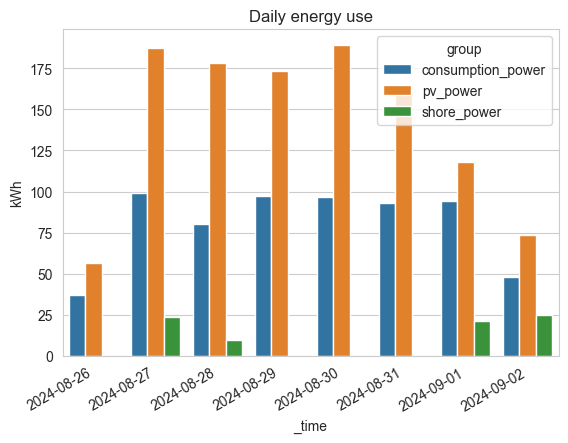

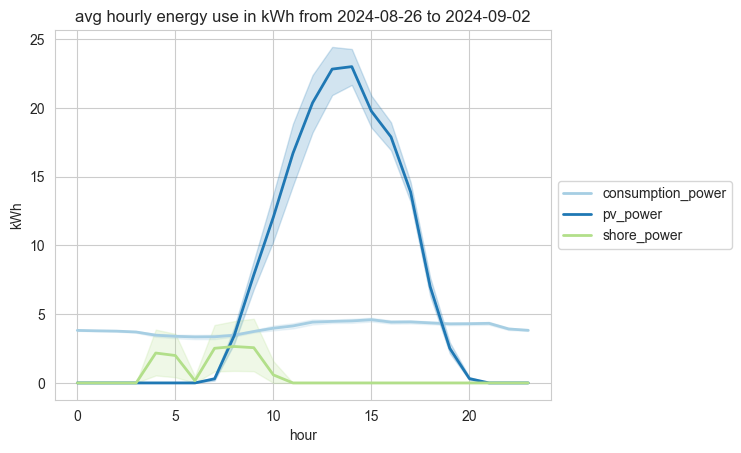

In [449]:
aggregate_electric = kw_electric.T.groupby(electrical_groups_dict_inv).sum().T

plot_daily_bars(aggregate_electric)
plot_hourly_avg(aggregate_electric)

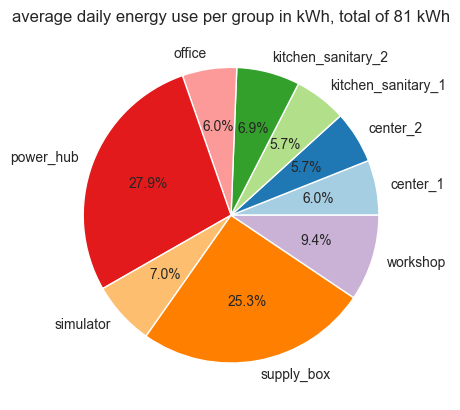

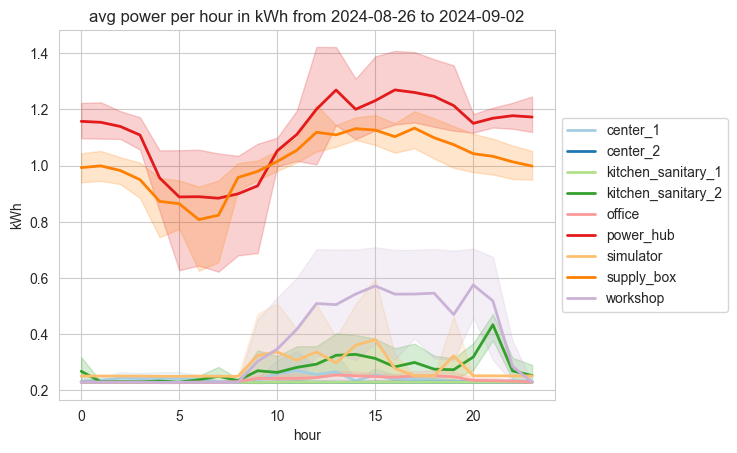

In [440]:
hourly_consumption_per_group = kwh_data.T.groupby(electrical_consumption_groups_dict_inv).sum().T.resample('h').mean()
daily_consumption_per_group = hourly_consumption_per_group.resample('d').sum()
daily_consumption_means = daily_consumption_per_group.mean()
plt.pie(daily_consumption_means, labels =daily_consumption_means.index, autopct='%1.1f%%', colors = sns.color_palette("Paired"))
plt.title(f'average daily energy use per group in kWh, total of {daily_consumption_per_group.mean().sum():.0f} kWh')

plot_hourly_avg(hourly_consumption_per_group)

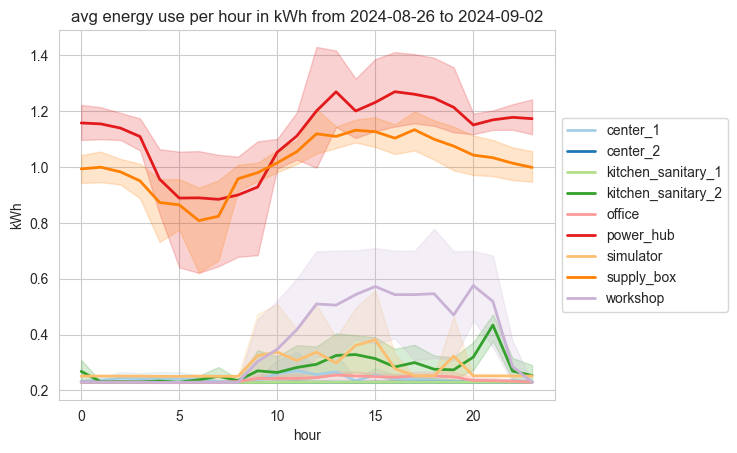

## Thermal 

In [458]:
thermal_variables = [
    #"heat_pipes_power",
    "cold_reservoir_cooling_demand",
    "cold_reservoir_cooling_supply",
    #"yazaki_chill_power",
    "chiller_chill_power",
]

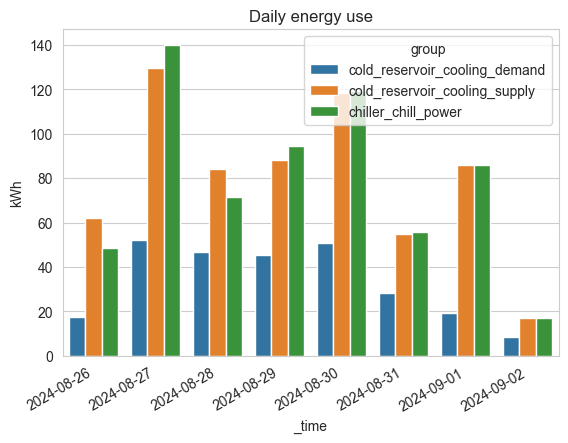

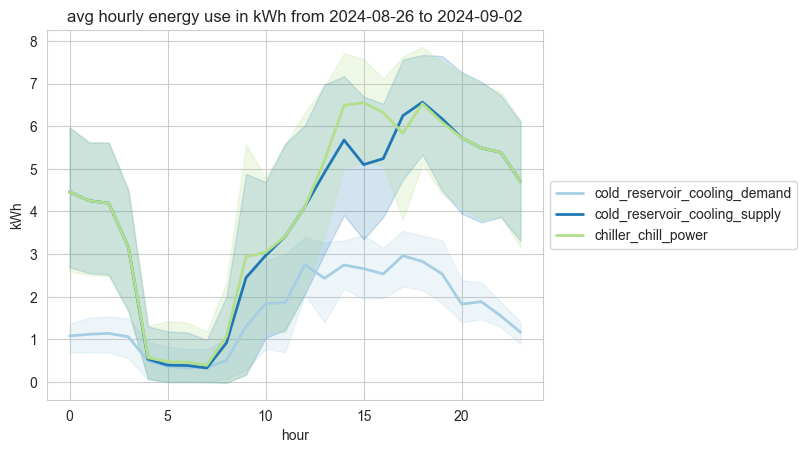

In [459]:
kw_thermal = raw_data[thermal_variables] / 1000

aggregate_thermal = kw_thermal.resample('h').mean() 

plot_daily_bars(aggregate_thermal)
plot_hourly_avg(aggregate_thermal)

# Water

water_maker_total_production                      24941.337396
fresh_to_kitchen_flow_sensor_total_volume             2.162540
technical_to_wash_off_flow_sensor_total_volume        0.305130
technical_to_sanitary_flow_sensor_total_volume        1.375326
dtype: float64

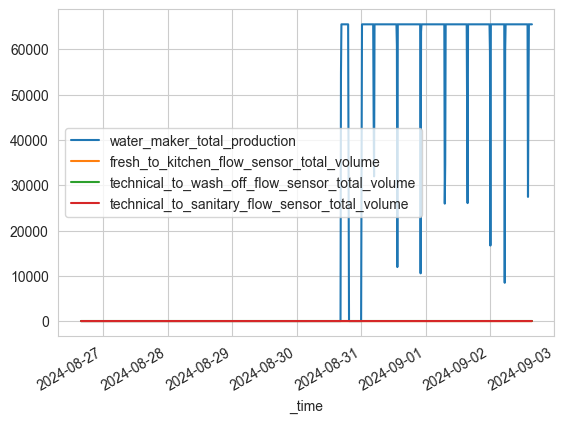

In [464]:
water = raw_data[water_variables]

water.plot()
water.mean()
#Looks like we have some conversion issues.. 